# Ćwiczenie 2 - Algorytmy ewolucyjne i genetyczne
## Implementacja algorytmu ewolucyjnego z selekcją ruletkową, krzyżowaniem jednopunktowym, mutacją gaussowską oraz sukcesją generacyjną.

### Importowanie modułów
- potrzebnych do wykonania ćwiczenia. W realizacji algorytmu korzystam z biblioteki math, random, numpy oraz copy,

In [2]:
import math
import random
import numpy as np
import copy
from typing import List, Tuple

- potrzebnych do wygenerowania wykresów stanowiących wizualizację działania algorytmu.

In [ ]:
import matplotlib.pyplot as plt

### Definicja klasy FactoryResource

Na potrzeby ćwiczenia definiujemy klasę FactoryResource. Reprezentuje ona "zakłady" dostarczające zasoby, z jakich nasza fabryka (której optymalne położenie będziemy później za pomocą algorytmu ewolucyjnego poszukiwać) będzie korzystać. Klasa ta przechowuje informacje takie jak:
 - *nazwa zakładu* - w celu ich uporządkowania jako nazwy przyjęłam kolejne liczby naturalne),
  - *współrzędne* - określają dokładne położenie zakładu w przestrzeni badanej R<sup>n</sup>,
  - *ilość dostarczanych zasobów* - mówi nam, ile zasobów dany zakład przekazuje naszej fabryce (jest to istotne w dalszych obliczeniach m.in. kosztu ich transportu).

Oprócz konstruktora klasy, został zaimplementowany niezbędny getter - do współrzędnych danego zakładu.

In [3]:
class FactoryResource: # zmienić nazwę na osobnika?
    """
    Class FactoryResource. Contains attributes:
    :param name:
    :param coordinates:
    :param quantity_of_resources_provided:
    """

    def __init__(self, name: int, coordinates: List[float], quantity_of_resources_provided: int = 0) -> None:
        """

        :param name:
        :param coordinates:
        :param quantity_of_resources_provided:
        """
        self.name = name # nazwa (po prostu który to jest w kolejności zasób)
        self.coordinates = coordinates
        self.provided_resources = quantity_of_resources_provided # czy zrobić to prywatnym?

    def get_coordinates(self):
        """

        :return:
        """
        return self.coordinates

Czy potrzebuję poniższej metody?

In [4]:

    def set_provided_resources(self, quantity_of_resources_provided):
        """

        :param quantity_of_resources_provided:
        :return:
        """

        self.provided_resources = quantity_of_resources_provided

### Definicja klasy Factory

Jest to klasa reprezentująca osobniki należące do populacji, na której przeprowadzane jest działanie algorytmu ewolucyjnego. Klasa ta w postaci atrybutów zawiera takie informacje, jak:
- *nazwa generacji* - w postaci liczby naturalnej mówi nam, jakim kolejnym pokoleniem potomków początkowej populacji jest dany osobnik (inicjalizująca algorytm populacja ma generację równą 1),
- *współrzędne osobnika* - lista, która zawiera współrzędne fabryki w przestrzeni n-wymiarowej (ilość współrzędnych wskazuje nam liczbę wymiarów badanego obszaru),
- *wartość otrzymana z funkcji oceny* - w formie liczby całkowitej mówi nam o jakości danego osobnika,
- *prawdopodobieństwo sukcesji* - wyliczone w oparciu o wartość otrzymanej oceny osobnika, ma wpływ na szansę osobnika w przeżyciu (wybraniu do dalszej sukcesji).

Oprócz konstruktora klasy (który wymaga podania jako parametrów wywołania nazwy generacji oraz współrzędnych) dla wspomnianej klasy zostały zaimplementowane niezbędne gettery oraz settery do poszczególnych atrybutów.

In [5]:

class Factory:
    """

    """

    def __init__(self, generation: int, coordinates: List[float]) -> None:
        """

        :param generation:
        :param coordinates:
        """
        self.generation_name = generation
        self.coordinates = coordinates
        self.fitness_score = float('inf')
        self.succession_probability = 0

    def get_generation_name(self):
        """

        :return:
        """

        return self.generation_name


    def get_coordinates(self):
        """

        :return:
        """

        return self.coordinates

    def set_coordinates(self, new_coordinates):
        """

        :param new_coordinates:
        :return:
        """

        self.coordinates = new_coordinates

    def set_one_coordinate(self, new_coordinate, position):
        """

        :param new_coordinate:
        :param position:
        :return:
        """

        self.coordinates[position] = new_coordinate

    # def add_coordinate(self, new_dimension_coordinate):

    #     self.get_coordinates().append(new_dimension_coordinate)

    def get_fitness_score(self):
        """

        :return:
        """

        return self.fitness_score

    def set_fitness_score(self, new_fitness_score: int):

        self.fitness_score = new_fitness_score

    def get_succession_probability(self):
        """

        :return:
        """

        return self.succession_probability

    def set_succession_probability(self, new_succession_probability):
        """

        :param new_succession_probability:
        :return:
        """

        self.succession_probability = new_succession_probability


    def __eq__(self, other_individual: 'Factory') :
        if self.get_coordinates() == other_individual.get_coordinates():
            return True
        else:
            return False


### Definicja klasy EvolutionaryAlgorithm

Jest to klasa reprezentująca badany w tym ćwiczeniu. Zawiera ona implementację algorytmu ewolucyjnego oraz stanowi swoistą pamięć dla tego algorytmu. Klasa ta została zaimplementowana w sposób jak najbardziej uniwersalny - jej atrybutami są:
- *lista zasobów* - są one niezbędne do działania naszego algorytmu (bez nich nie byłby on w stanie działać),
- *rozmiar populacji* - ustawiony przez użytkownika determinuje, jak duża populacja zostanie wygenerowana,
- *najlepszy osobnik* - jest to pole klasy, które jako jedno z dwóch współtworzy pamięć naszego algorytmu - przechowuje informacje o najlepszym ze wszystkich wygenerowanych (do tej pory) populacji,
- *ocena najlepszego osobnika* - jest to druga połowa "pamięci" algorytmu - przechowywany jest tu oddzielnie najlepszy wynik (funkcji oceny) uzyskany przez najbardziej odpowiedniego (dotychczas) osobnika,
- *aktualna populacja* - zawiera aktualną populację, która to w przebiegu metody algorytmu ewolucyjnego poddana zostanie różnym operacjom genetycznym,

Ze względu na chęć utworzenia klasy, która w swym działaniu będzie jak najbardziej uniwersalna, nie została wewnątrz klasy zdefiniowana metoda generowania populacji - funkcja generująca pierwotną populację algorytmu musi zostać podana przez użytkownika (jako parametr konstruktora klasy). Konstruktor klasy Evolutionary Algorithm został stworzony więc tak, aby oprócz stałych (i zawsze wymaganych parametrów) - takich jak liczba zakładów, rozmiar populacji oraz funkcja generująca populację była możliwość przekazania (ewentualnych) niezbędnych do działania argumentów wywołania funkcji tworzącej początkową populację.

Klasa ta oprócz metod takich jak gettery i settery, dających bezpośredni dostęp do pól klasy, ma zaimplementowane metody, które mają bezpośredni wpływ na dotychczasową populację - jest to funkcja m.in. sortująca i ustawiająca w odpowiedniej kolejności osobników (na podstawie otrzymanej oceny danego osobnika), obliczająca prawdopodobieństwo sukcesji (również na podstawie "jakości" osobnika) oraz selekcji ruletkowej - są to bowiem metody w algorytmie ewolucyjnym które działają na początkowym (w wykonaniu danej pętli) zbiorze osobników. (Dalsze metody algorytmu ewolucyjnego z racji tego że działają na zbiorach osobników będących populacjami tymczasowymi, czyli tymi, niezwiązanymi z polem current_population klasy Evolutionary Algorithm (nie są populacją przechowywaną w tej klasy), zostały zaimplementowane "na zewnątrz" niej.

In [6]:
class EvolutionaryAlgorithm:


    def __init__(self, factory_resources: List[FactoryResource], population_size: int, generate_population_function: callable, *generate_population_parameters) -> None:
        """
        EvolutionaryAlgorithm class constructor. Contains attributes:
        :param factory_resources:
        :param population_size:
        """
        self.factory_resources = factory_resources
        self.population_size = population_size
        self.best_individual = None
        self.best_individual_score = None
        self.current_population = generate_population_function(factory_resources, population_size, *generate_population_parameters)
        # self.current_population_name = 1 - CZY POTRZEBUJĘ TEGO POLA?


    def get_current_population(self):
        """

        :return:
        """
        return self.current_population

    def set_population(self, new_population: List[Factory]):
        """

        :param new_population:
        :return:
        """
        self.current_population = new_population

    def get_factory_resources(self):
        """

        :return:
        """
        return self.factory_resources

    def get_best_individual(self):
        """

        :return:
        """
        return self.best_individual

    def set_new_best_individual(self):
        """

        :return:
        """
        self.best_individual = copy.deepcopy(self.current_population[0])

    def set_new_best_individual_score(self):
        """

        :return:
        """
        self.best_individual_score = self.best_individual.get_fitness_score()

    def get_population_size(self):
        """

        :return:
        """
        return self.population_size

    def fitness_function(self, specified_fitness_function: callable):
        """

        :return:
        """
        specified_fitness_function(self.get_current_population(), self.get_factory_resources())
        self.fitness_sort_factories()

    def update_factories_fitness_score(self):
        """

        :return:
        """
        for each_factory in self.get_current_population():
            new_fitness_score = 0
            for each_factory_resource in self.get_factory_resources():
                distance = calculate_manhattan_metric(each_factory, each_factory_resource)
                transport_cost = calculate_individual_transport_cost(distance)
                new_fitness_score += transport_cost
            each_factory.set_fitness_score(new_fitness_score)

    def fitness_sort_factories(self):
        """

        :return:
        """
        self.set_population(sorted(self.get_current_population(), key=lambda individuals: individuals.get_fitness_score()))  # usunęłam tu reverse = true

    def roulette_selection(self) -> List[Factory]:
        """

        :return:
        """
        self.succession_probability()
        chosen_individuals = random.choices((self.get_current_population()), weights=[individual.get_succession_probability() for individual in self.get_current_population()], k=self.get_population_size())
        selected_individuals = [copy.deepcopy(individual) for individual in chosen_individuals]
        return selected_individuals

    def succession_probability(self):
        """

        :return:
        """
        for eligibility_position, individual in enumerate(self.get_current_population(), start=0):
            numerator = self.get_population_size() - eligibility_position
            denominator = self.get_population_size()*(self.get_population_size() + 1) / 2
            new_probability = numerator / denominator
            individual.set_succession_probability(new_probability)


    # fitness_function: callable, primary_population: List[Factory], population_size: int, - usunęłam to z argumentów wywołania funkcji, ponieważ stwierdziłam, że funkcja ta zostanie metodą klasy
    def evolutionary_algorithm(self, specified_fitness_function:callable, mutation_rate: float, crossover_probability: float, maximum_iterations: int) -> Tuple[List[List[Factory]], Factory]:
        """

        :param specified_fitness_function:
        :param mutation_rate:
        :param crossover_probability:
        :param maximum_iterations:
        :return:
        """
        analysed_points = [copy.deepcopy(self.get_current_population())]
        iteration_counter = 0
        self.fitness_function(specified_fitness_function)
        self.set_new_best_individual()
        self.set_new_best_individual_score()
        while iteration_counter < maximum_iterations:
            selected_population = self.roulette_selection()
            #########################
            print(iteration_counter)
            print(len(selected_population))
            ########################
            mutated_population = gaussian_mutation(selected_population, mutation_rate)
            print(len(mutated_population))
            crossbred_population = crossover(mutated_population, crossover_probability)
            print(len(crossbred_population))
            print(" ")
            #######################
            analysed_points += [copy.deepcopy(crossbred_population)]
            self.set_population(crossbred_population)
            self.fitness_function(specified_fitness_function)
            if self.get_best_individual().get_fitness_score() > self.current_population[0].get_fitness_score():
                self.set_new_best_individual()
                self.set_new_best_individual_score()
            iteration_counter +=1

        return analysed_points, self.get_best_individual()

### Omówienie działania algorytmu ewolucyjnego
#### (implementacja powyżej)


In [7]:

def calculate_manhattan_metric(analysed_factory: Factory, analysed_factory_resource: FactoryResource): # pierwszy point - badany punkt, drugi point - fabryki
    """

    :param analysed_factory:
    :param analysed_factory_resource:
    :return:
    """
    distance = 0
    for each_dimension in range(len(analysed_factory.get_coordinates())):
        distance += abs(analysed_factory.get_coordinates()[each_dimension] - analysed_factory_resource.get_coordinates()[each_dimension])
    return distance


def calculate_individual_transport_cost(distance):
    """

    :param distance:
    :return:
    """

    transport_cost = 1 - math.e**(-distance)
    return transport_cost

def factory_fitness_function(provided_population_to_evaluate: List[Factory], provided_resources: List[FactoryResource]):
    """

    :return:
    """
    for each_factory in provided_population_to_evaluate:
        new_fitness_score = 0
        for each_factory_resource in provided_resources:
            distance = calculate_manhattan_metric(each_factory, each_factory_resource)
            transport_cost = calculate_individual_transport_cost(distance)
            new_fitness_score += transport_cost
        each_factory.set_fitness_score(new_fitness_score)


In [8]:

# zmienić nazwę na before crossover
def crossover(population_before_crossover: List[Factory], crossover_probability: float):
    """

    :param population_before_crossover:
    :param crossover_probability:
    :return:
    """
    population_after_crossover = []
    population_chosen_to_crossover, passed_forward_population = choose_parents_for_crossover(population_before_crossover, crossover_probability)
    population_after_crossover += passed_forward_population
    for position in range(0, len(population_chosen_to_crossover), 2):
        children = single_point_crossover(population_before_crossover[position], population_before_crossover[position + 1])
        population_after_crossover += children
        ########################################
    children_generated_after_genetic_operations = [copy.deepcopy(individual) for individual in population_after_crossover]
        ########################################
    return children_generated_after_genetic_operations

In [9]:
def choose_parents_for_crossover(population_to_crossover: List[Factory], crossover_probability: float) -> Tuple[List[Factory], List[Factory]]:
    """

    :param population_to_crossover:
    :param crossover_probability:
    :return:
    """
    population_chosen_to_crossover = []
    passed_forward_population = []
    for each_individual in population_to_crossover:
        individual_probability_to_crossover = np.random.uniform(low = 0, high = 1)
        if (len(population_chosen_to_crossover) % 2 == 0 and each_individual == population_to_crossover[-1]) or individual_probability_to_crossover < crossover_probability:  # dodałam warunek ponieważ był błąd nie sprawdziłam jeszcze czy poprawnie działa
            passed_forward_population.append(each_individual)
            continue
        if (len(population_chosen_to_crossover) % 2 != 0 and each_individual == population_to_crossover[-1]) or individual_probability_to_crossover >= crossover_probability:  # możliwe że problematyczne miejsce w kodzie
            population_chosen_to_crossover.append(each_individual)
            continue
    return population_chosen_to_crossover, passed_forward_population  # na wyjściu muszę otrzymać dwa zbiory: do krzyżowania, który jest parzysty oraz te co przechodzą dalej (jakikolwiek)


In [10]:
#dostaje listę rodziców
def single_point_crossover(first_individual: Factory, second_individual: Factory) -> List[Factory]:
    """

    :param first_individual:
    :param second_individual:
    :return:
    """
    new_generation_name = max(first_individual.get_generation_name(), second_individual.get_generation_name()) + 1
    dimensions = len(first_individual.get_coordinates())
    slicing_point = random.randint(1, dimensions - 1)
    first_child_genes = first_individual.get_coordinates()[:slicing_point] + second_individual.get_coordinates()[slicing_point:] #naprawione, bo źle cieło
    second_child_genes = second_individual.get_coordinates()[:slicing_point] + first_individual.get_coordinates()[slicing_point:]
    children = [Factory(new_generation_name, first_child_genes),
                Factory(new_generation_name, second_child_genes)]
    return children


In [11]:

def gaussian_mutation(population: List[Factory], mutation_rate: float):
    """

    :param population:
    :param mutation_rate:
    :return:
    """
    for each_individual in population:
        for count, each_coordinate in enumerate(each_individual.get_coordinates()):  # błędo genny kod bo nie sprawdzony
            each_individual.set_one_coordinate(perform_gaussian_mutation(each_coordinate, mutation_rate), count)
    return population

def perform_gaussian_mutation(provided_coordinate: float, mutation_rate: float):
    """

    :param provided_coordinate:
    :param mutation_rate:
    :return:
    """

    mutated_coordinate = np.random.normal(provided_coordinate, mutation_rate)
    # mutated_coordinate = provided_coordinate + mutation
    return mutated_coordinate

In [12]:
def generate_population(factory_resources: List[FactoryResource], population_size, minimal_range, maximal_range) -> List[Factory]:
    """

    :param factory_resources:
    :param population_size:
    :param minimal_range:
    :param maximal_range:
    :return:
    """
    initial_population = []
    dimensions = len(factory_resources[0].get_coordinates())
    for _ in range(population_size):
        individuals_coordinates = []
        for _ in range(dimensions):
            i_coordinate = minimal_range + np.random.rand()*(maximal_range - minimal_range)
            individuals_coordinates.append(i_coordinate)
        new_individual = Factory(1, individuals_coordinates)
        initial_population.append(new_individual)
    return initial_population




In [74]:

resources = [FactoryResource(1, [1, 1], 20), FactoryResource(2, [-0.5, 1], 10), FactoryResource(3, [-1, -0,5], 5), FactoryResource(4, [1, -1], 10)]

algorithm = EvolutionaryAlgorithm(resources, 10, generate_population, -1, 1)
# print(algorithm.get_current_population())
lista_jakas, osobnik_idealny = algorithm.evolutionary_algorithm(factory_fitness_function, 3, 0.3, 1000)

print(lista_jakas)



# for each_generation in lista_jakas:
#     print(len(each_generation))
#     for each_element in each_generation:
#         print(each_element.get_coordinates(), each_element.get_generation_name())
# print(len(lista_jakas))
# print(osobnik_idealny.get_coordinates(), osobnik_idealny.get_generation_name())

0
10
10
10
 
1
10
10
10
 
2
10
10
10
 
3
10
10
10
 
4
10
10
10
 
5
10
10
10
 
6
10
10
10
 
7
10
10
10
 
8
10
10
10
 
9
10
10
10
 
10
10
10
10
 
11
10
10
10
 
12
10
10
10
 
13
10
10
10
 
14
10
10
10
 
15
10
10
11
 
16
10
10
11
 
17
10
10
10
 
18
10
10
10
 
19
10
10
10
 
20
10
10
10
 
21
10
10
10
 
22
10
10
11
 
23
10
10
10
 
24
10
10
10
 
25
10
10
10
 
26
10
10
10
 
27
10
10
10
 
28
10
10
10
 
29
10
10
10
 
30
10
10
10
 
31
10
10
10
 
32
10
10
10
 
33
10
10
10
 
34
10
10
10
 
35
10
10
11
 
36
10
10
11
 
37
10
10
10
 
38
10
10
10
 
39
10
10
10
 
40
10
10
10
 
41
10
10
11
 
42
10
10
10
 
43
10
10
11
 
44
10
10
10
 
45
10
10
11
 
46
10
10
10
 
47
10
10
10
 
48
10
10
10
 
49
10
10
10
 
50
10
10
10
 
51
10
10
10
 
52
10
10
11
 
53
10
10
10
 
54
10
10
10
 
55
10
10
10
 
56
10
10
10
 
57
10
10
10
 
58
10
10
10
 
59
10
10
10
 
60
10
10
10
 
61
10
10
10
 
62
10
10
10
 
63
10
10
10
 
64
10
10
10
 
65
10
10
10
 
66
10
10
10
 
67
10
10
10
 
68
10
10
10
 
69
10
10
10
 
70
10
10
10
 
71
10
10
10
 
72

## Graficzna reprezentacja działania algorytmu

### Importowanie modułów -
potrzebnych do wygenerowania wykresów stanowiących wizualizację działania algorytmu

[[-5.0, -5.0], [-4.997999599919984, -4.997999599919984], [-4.995999199839968, -4.995999199839968], [-4.993998799759952, -4.993998799759952], [-4.991998399679936, -4.991998399679936], [-4.98999799959992, -4.98999799959992], [-4.987997599519904, -4.987997599519904], [-4.985997199439888, -4.985997199439888], [-4.983996799359872, -4.983996799359872], [-4.981996399279856, -4.981996399279856], [-4.97999599919984, -4.97999599919984], [-4.977995599119824, -4.977995599119824], [-4.975995199039808, -4.975995199039808], [-4.973994798959792, -4.973994798959792], [-4.971994398879776, -4.971994398879776], [-4.96999399879976, -4.96999399879976], [-4.967993598719744, -4.967993598719744], [-4.965993198639728, -4.965993198639728], [-4.963992798559712, -4.963992798559712], [-4.961992398479696, -4.961992398479696], [-4.95999199839968, -4.95999199839968], [-4.957991598319664, -4.957991598319664], [-4.955991198239648, -4.955991198239648], [-4.953990798159632, -4.953990798159632], [-4.951990398079616, -4.951

In [76]:
def graph_calculate_manhattan_metric(analysed_point: List[int], analysed_factory_resource: FactoryResource): # pierwszy point - badany punkt, drugi point - fabryki
    """

    :param analysed_point:
    :param analysed_factory_resource:
    :return:
    """
    distance = 0
    for each_dimension in range(len(analysed_point)):
        distance += abs(analysed_point[each_dimension] - analysed_factory_resource.get_coordinates()[each_dimension])
    return distance


def calculate_individual_transport_cost(distance):
    """

    :param distance:
    :return:
    """

    transport_cost = 1 - math.e**(-distance)
    return transport_cost

def graph_factory_fitness_function(provided_points_to_evaluate: List[List[int]], provided_resources: List[FactoryResource]):
    """

    :return:
    """
    calculated_z_values = []
    for point in provided_points_to_evaluate:
        new_fitness_score = 0
        for each_factory_resource in provided_resources:
            distance = graph_calculate_manhattan_metric(point, each_factory_resource)
            transport_cost = calculate_individual_transport_cost(distance)
            new_fitness_score += transport_cost
        calculated_z_values.append(new_fitness_score)
    return calculated_z_values

def extract_coordinates_data(results_analysed_populations:List[List[Factory]]):
    x_coordinates = []
    y_coordinates = []
    for each_generation in results_analysed_populations:
        for each_individual in each_generation:
            x_coordinates.append(each_individual.get_coordinates()[0])
            y_coordinates.append(each_individual.get_coordinates()[1])
    return x_coordinates, y_coordinates

[<__main__.Factory object at 0x00000217332E04F0>, <__main__.Factory object at 0x00000217332E31C0>, <__main__.Factory object at 0x00000217332E3BB0>, <__main__.Factory object at 0x00000217332E0580>, <__main__.Factory object at 0x00000217332E36A0>, <__main__.Factory object at 0x00000217332E0910>, <__main__.Factory object at 0x00000217332E0AF0>, <__main__.Factory object at 0x00000217332E3730>, <__main__.Factory object at 0x000002173384E740>, <__main__.Factory object at 0x0000021728366BC0>]
0
10
10
10
 
1
10
10
10
 
2
10
10
10
 
3
10
10
10
 
4
10
10
10
 
5
10
10
10
 
6
10
10
10
 
7
10
10
10
 
8
10
10
10
 
9
10
10
10
 
10
10
10
10
 
11
10
10
10
 
12
10
10
10
 
13
10
10
10
 
14
10
10
10
 
15
10
10
11
 
16
10
10
11
 
17
10
10
10
 
18
10
10
10
 
19
10
10
10
 
20
10
10
10
 
21
10
10
10
 
22
10
10
11
 
23
10
10
10
 
24
10
10
10
 
25
10
10
10
 
26
10
10
10
 
27
10
10
10
 
28
10
10
10
 
29
10
10
10
 
30
10
10
10
 
31
10
10
10
 
32
10
10
10
 
33
10
10
10
 
34
10
10
10
 
35
10
10
11
 
36
10
10
11
 
3

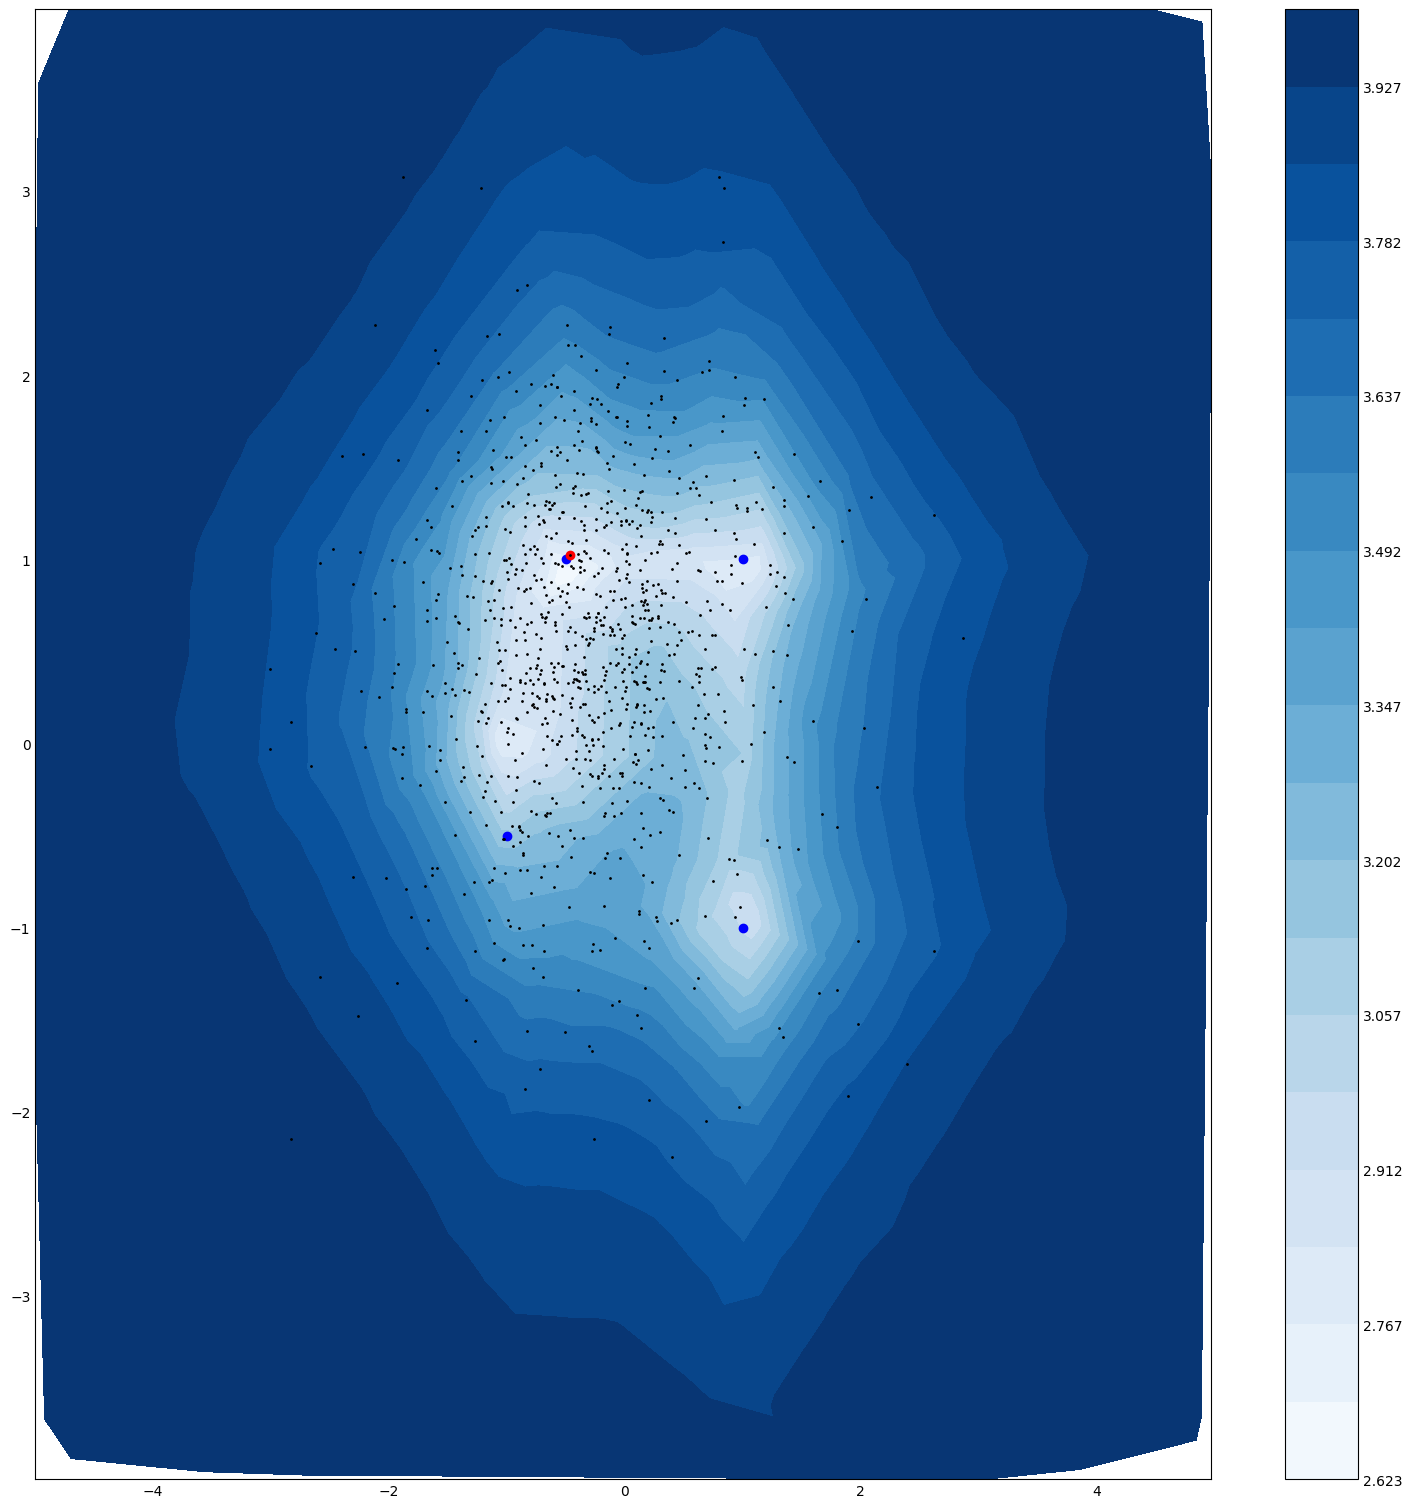

In [98]:
resources = [FactoryResource(1, [1, 1], 20), FactoryResource(2, [-0.5, 1], 10), FactoryResource(3, [-1, -0,5], 5), FactoryResource(4, [1, -1], 10)]

algorithm = EvolutionaryAlgorithm(resources, 10, generate_population, -1, 1)
print(algorithm.get_current_population())
analysed_generations, best_individual = algorithm.evolutionary_algorithm(factory_fitness_function, 0.5, 0.3, 100)


plt.style.use('_mpl-gallery-nogrid')
plt.rcParams["figure.figsize"] = (15, 15)
#####################################################################################################################
resources_coord = [[1, -0.5, -1, 1],[1, 1, -0,5, -1]]
x_coordinates, y_coordinates = extract_coordinates_data(analysed_generations)


np.random.seed(1)
x_values = np.random.uniform(-5, 5, 1000)
y_values = np.random.uniform(-4, 4, 1000)
coordinates_in_graph = [[x, y] for x, y in zip(x_values, y_values)]
z_values = np.array(graph_factory_fitness_function(coordinates_in_graph, resources))

levels = np.linspace(z_values.min(), z_values.max(), 20)
fig, ax = plt.subplots()

# ax.plot(x_values, y_values, 'o', markersize=2, color='grey')
# plt.xlabel('X axis', fontsize=10)
# plt.ylabel('Y axis', fontsize=10)
ax.plot(x_coordinates, y_coordinates, 'o', markersize=1, color='k')
ax.tricontourf(x_values, y_values, z_values, levels=levels)
graph = ax.tricontourf(x_values, y_values, z_values, levels=levels)
fig.colorbar(graph)
ax.scatter([1, -0.5, -1, 1], [1, 1, -0.5, -1], color='b')
ax.scatter(best_individual.get_coordinates()[0], best_individual.get_coordinates()[1], color='r')




plt.show()

[<__main__.Factory object at 0x0000021733431930>, <__main__.Factory object at 0x0000021733430640>, <__main__.Factory object at 0x0000021733432320>, <__main__.Factory object at 0x0000021733431030>, <__main__.Factory object at 0x00000217334301C0>, <__main__.Factory object at 0x0000021733432050>, <__main__.Factory object at 0x0000021733430730>, <__main__.Factory object at 0x0000021733430F10>, <__main__.Factory object at 0x0000021733431690>, <__main__.Factory object at 0x0000021733433910>]
0
10
10
10
 
1
10
10
10
 
2
10
10
10
 
3
10
10
10
 
4
10
10
10
 
5
10
10
10
 
6
10
10
10
 
7
10
10
10
 
8
10
10
10
 
9
10
10
10
 
10
10
10
10
 
11
10
10
10
 
12
10
10
10
 
13
10
10
10
 
14
10
10
10
 
15
10
10
11
 
16
10
10
11
 
17
10
10
10
 
18
10
10
10
 
19
10
10
10
 
20
10
10
10
 
21
10
10
10
 
22
10
10
11
 
23
10
10
10
 
24
10
10
10
 
25
10
10
10
 
26
10
10
10
 
27
10
10
10
 
28
10
10
10
 
29
10
10
10
 
30
10
10
10
 
31
10
10
10
 
32
10
10
10
 
33
10
10
10
 
34
10
10
10
 
35
10
10
11
 
36
10
10
11
 
3

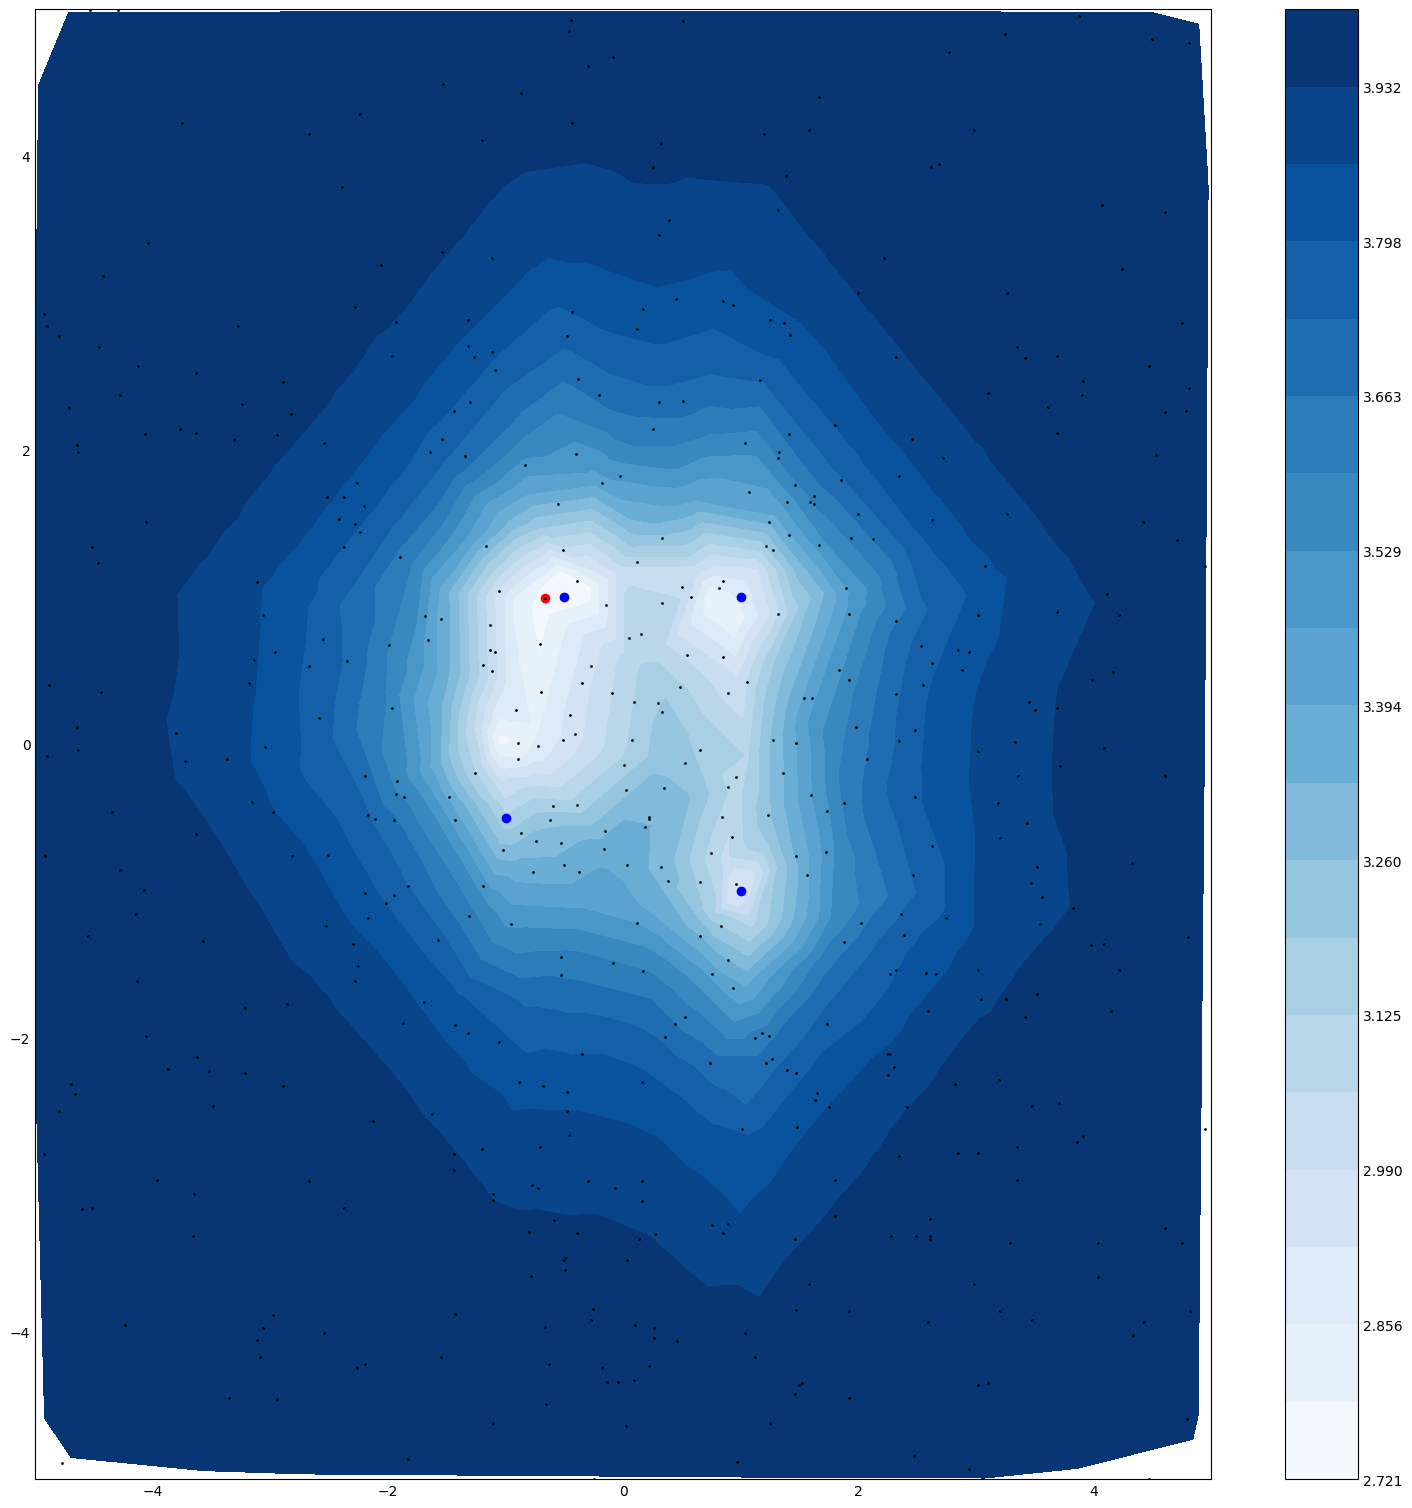

In [97]:
resources = [FactoryResource(1, [1, 1], 20), FactoryResource(2, [-0.5, 1], 10), FactoryResource(3, [-1, -0,5], 5), FactoryResource(4, [1, -1], 10)]

algorithm = EvolutionaryAlgorithm(resources, 10, generate_population, -1, 1)
print(algorithm.get_current_population())
analysed_generations, best_individual = algorithm.evolutionary_algorithm(factory_fitness_function, 3, 0.3, 100)

import matplotlib.pyplot as plt
import numpy as np
plt.style.use('_mpl-gallery-nogrid')
plt.rcParams["figure.figsize"] = (15, 15)
#####################################################################################################################
# resources_coord = [[1, -0.5, -1, 1],[1, 1, -0,5, -1]]
x_coordinates, y_coordinates = extract_coordinates_data(analysed_generations)


np.random.seed(1)
x_values = np.random.uniform(-5, 5, 1000)
y_values = np.random.uniform(-5, 5, 1000)
coordinates_in_graph = [[x, y] for x, y in zip(x_values, y_values)]
z_values = np.array(graph_factory_fitness_function(coordinates_in_graph, resources))

levels = np.linspace(z_values.min(), z_values.max(), 20)
fig, ax = plt.subplots()

# ax.plot(x_values, y_values, 'o', markersize=2, color='grey')
# plt.xlabel('X axis', fontsize=10)
# plt.ylabel('Y axis', fontsize=10)
ax.plot(x_coordinates, y_coordinates, 'o', markersize=1, color='k')
graph = ax.tricontourf(x_values, y_values, z_values, levels=levels)
fig.colorbar(graph)
ax.scatter([1, -0.5, -1, 1], [1, 1, -0.5, -1], color='b')
ax.scatter(best_individual.get_coordinates()[0], best_individual.get_coordinates()[1], color='r')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)



plt.show()